# Win's statistical clustering project

Statistical clustering of linear measurements of post crania can predict species and/or sex for artiodactyls

Goal # 0: Replicate Win's work so far: the MANOVA

Goal # 1: Predict species

Goal # 2: Predict sex using a neural network

Step 1: Import data & libraries

In [1]:
#import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.multivariate.manova import MANOVA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
#I need to update this file so that it also includes a column for family. I can get this using the dict I made this mornin and saving it into a csv. 

df = pd.read_csv('Data_for_Nick.csv', 
                 dtype={'Institution': object, 
                        'specimen #': object, 
                        'Genus': object, 
                        'species': object, 
                        'sub-species': object, 
                        'sex': object, 
                        'Unnamed: 6': object, 
                        'LL': np.float64, 
                        'LI': np.float64, 
                        'LM': np.float64, 
                        'WI': np.float64, 
                        'WD': np.float64, 
                        'TP': np.float64, 
                        'TI': np.float64, 
                        'TD': np.float64
                       }
                )


In [3]:
df.head(1)

,Institution,specimen #,Genus,species,sub-species,sex,family,LL,LI,LM,WI,WD,TP,TI,TD
0,AMNH,85150,Aepyceros,Aepyceros melampus,Aepceryos melampus suara,M,Bovidae,36.5,28.2,34.0,21.0,20.9,13.6,19.0,16.2


Step 2: Feature Exploration

In [4]:
#look at the dataframe's general info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 283 entries, 0 to 282
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Institution  283 non-null    object 
 1   specimen #   283 non-null    object 
 2   Genus        283 non-null    object 
 3   species      283 non-null    object 
 4   sub-species  239 non-null    object 
 5   sex          275 non-null    object 
 6   family       283 non-null    object 
 7   LL           282 non-null    float64
 8   LI           282 non-null    float64
 9   LM           282 non-null    float64
 10  WI           282 non-null    float64
 11  WD           282 non-null    float64
 12  TP           282 non-null    float64
 13  TI           282 non-null    float64
 14  TD           282 non-null    float64
dtypes: float64(8), object(7)
memory usage: 33.3+ KB


In [5]:
#Look at the distibution of NaN values
df.isna().sum()

Institution     0
specimen #      0
Genus           0
species         0
sub-species    44
sex             8
family          0
LL              1
LI              1
LM              1
WI              1
WD              1
TP              1
TI              1
TD              1
dtype: int64

In [6]:
df.isnull().sum()

Institution     0
specimen #      0
Genus           0
species         0
sub-species    44
sex             8
family          0
LL              1
LI              1
LM              1
WI              1
WD              1
TP              1
TI              1
TD              1
dtype: int64

divide the measurements into numeric type:

In [7]:
#df_lengths will be a dataframe containing only the measurements of bone morphology
df_lengths = df.select_dtypes(include=[np.float])

... and catagorical type data:

In [8]:
df_objs = df.select_dtypes(include=['object'])

In [9]:
#remove 'Insitution', 'specimen #', 'sub-species', and 'Unnamed' 
df_objs.drop(['Institution', 'specimen #', 'sub-species'], axis=1, inplace=True)

/Users/Nicholas/Desktop/Data Science Immersion/venvp3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


establish some other dataframes to use for the MANOVA

In [10]:
#length comparisons versus sex
df_lengths_sex = df_lengths.assign(sex=df['sex'].values)#wait, I need to add back the sex to the dataframe

#df_lengths_sex = pd.get_dummies(df_lengths_sex, columns = ['sex'])

#df_lengths_sex = df_lengths_species.dropna()

In [11]:
#length comparisions versus species
df_lengths_species = df_lengths.assign(species=df['species'].values)

#df_lengths_species = pd.get_dummies(df_lengths_species, columns = ['species'])

#df_lengths_species = df_lengths_species.dropna()

In [12]:
#length comparisons versus sub-species
df_lengths_sub_spec = df_lengths.assign(subspecies=df['sub-species'])

df_lengths_sub_spec.rename(columns={'subspecies':'sub-species'}, inplace=True)

#df_lengths_sub_spec = pd.get_dummies(df_lengths_sub_spec, columns = ['sub-species'])

#df_lengths_sub_spec = df_lengths_sub_spec.dropna()

In [13]:
#lengths comparisons versus genus
df_lengths_genus = df_lengths.assign(Genus=df['Genus'])

#df_lengths_genus = pd.get_dummies(df_lengths_genus, columns = ['Genus'])

In [14]:
def feature_importance(data, target, xlim):
    filled = data.dropna()
    X = filled.drop(target, axis = 1)
    X = pd.get_dummies(X, drop_first = True)
    y = filled[[target]]
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 0)
    rf = RandomForestClassifier(random_state = 1)
    rf.fit(X_train, y_train)
    Importance = pd.DataFrame(rf.feature_importances_, X.columns)
    Importance.columns = ['Importance']#have the be importance to target
    return Importance.sort_values(by = 'Importance', ascending = False).head(xlim)

In [15]:
#Feature imporatance to prediction using a random forest model
s1 = feature_importance(df_lengths_sex.dropna(), 'sex', 8)
s2 = feature_importance(df_lengths_genus.dropna(), 'Genus', 8)
s3 = feature_importance(df_lengths_species.dropna(), 'species', 8)

df_ = pd.concat([s1, s2, s3], axis=1)
df_.columns = ['sex', 'Genus', 'species']
df_

/Users/Nicholas/Desktop/Data Science Immersion/venvp3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/Users/Nicholas/Desktop/Data Science Immersion/venvp3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/Users/Nicholas/Desktop/Data Science Immersion/venvp3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


,sex,Genus,species
TP,0.140160,0.116363,0.113863
WI,0.129542,0.139752,0.142220
LM,0.128290,0.141884,0.143503
WD,0.126805,0.120505,0.120212
LL,0.126703,0.127549,0.129961
LI,0.124231,0.129067,0.131960
TD,0.117823,0.125382,0.116870
TI,0.106445,0.099498,0.101411


In [16]:
#save feature importance to send to Win
df_.to_csv('feature importance.csv')
#correlation only works for the numeric features
df.corr().to_csv('measurement correlation.csv')

plot the raw data in each measurement catagory, using a different color to show by family and by sex. 

In [17]:
#make all the nans into ? for later
df['sex'].fillna('?', inplace=True)

In [18]:
#break these into different dataframes by sex
def sort_by_sex(df):
    df_s_u = df.loc[df['sex'] == '?', ['LL', 'LI', 'LM', 'WI', 'WD', 'TP', 'TD']]
    df_s_f = df.loc[df['sex'] == 'F', ['LL', 'LI', 'LM', 'WI', 'WD', 'TP', 'TD']]
    df_s_m = df.loc[df['sex'] == 'M', ['LL', 'LI', 'LM', 'WI', 'WD', 'TP', 'TD']]
    return df_s_u, df_s_f, df_s_m
    
df_s_u, df_s_f, df_s_m = sort_by_sex(df)

In [19]:
def sort_by_family(df):
    df_f_b = df.loc[df['family'] == 'Bovidae', ['LL', 'LI', 'LM', 'WI', 'WD', 'TP', 'TD']]
    df_f_a = df.loc[df['family'] == 'Antilocapridae', ['LL', 'LI', 'LM', 'WI', 'WD', 'TP', 'TD']]
    df_f_m = df.loc[df['family'] == 'Camelidae', ['LL', 'LI', 'LM', 'WI', 'WD', 'TP', 'TD']]
    df_f_c = df.loc[df['family'] == 'Cervidae', ['LL', 'LI', 'LM', 'WI', 'WD', 'TP', 'TD']]
    df_f_p = df.loc[df['family'] == 'Palaeomerycidae', ['LL', 'LI', 'LM', 'WI', 'WD', 'TP', 'TD']]
    return df_f_b, df_f_a, df_f_m, df_f_c, df_f_p
    
df_f_b, df_f_a, df_f_m, df_f_c, df_f_p = sort_by_family(df)

In [20]:
def sort_by_species(df):
    df_p_aeme = df.loc[df['species'] == 'Aepyceros melampus', ['LL', 'LI', 'LM', 'WI', 'WD', 'TP', 'TD']]
    df_p_albu = df.loc[df['species'] == 'Alcelaphus buselaphus', ['LL', 'LI', 'LM', 'WI', 'WD', 'TP', 'TD']]
    df_p_cogn = df.loc[df['species'] == 'Connochaetes gnou', ['LL', 'LI', 'LM', 'WI', 'WD', 'TP', 'TD']]
    df_p_cota = df.loc[df['species'] == 'Connochaetes taurinus', ['LL', 'LI', 'LM', 'WI', 'WD', 'TP', 'TD']]
    df_p_dado = df.loc[df['species'] == 'Damaliscus dorcas', ['LL', 'LI', 'LM', 'WI', 'WD', 'TP', 'TD']]
    df_p_dahu = df.loc[df['species'] == 'Damaliscus hunteri', ['LL', 'LI', 'LM', 'WI', 'WD', 'TP', 'TD']]
    df_p_dalu = df.loc[df['species'] == 'Damaliscus lunatus', ['LL', 'LI', 'LM', 'WI', 'WD', 'TP', 'TD']]
    df_p_anma = df.loc[df['species'] == 'Antidorcas marsupialis', ['LL', 'LI', 'LM', 'WI', 'WD', 'TP', 'TD']]
    df_p_gagr = df.loc[df['species'] == 'Gazella granti', ['LL', 'LI', 'LM', 'WI', 'WD', 'TP', 'TD']]
    df_p_gath = df.loc[df['species'] == 'Gazella thomsoni', ['LL', 'LI', 'LM', 'WI', 'WD', 'TP', 'TD']]
    df_p_liwa = df.loc[df['species'] == 'Litocranius walleri', ['LL', 'LI', 'LM', 'WI', 'WD', 'TP', 'TD']]
    df_p_maki = df.loc[df['species'] == 'Madoqua kirki', ['LL', 'LI', 'LM', 'WI', 'WD', 'TP', 'TD']]
    df_p_neba = df.loc[df['species'] == 'Neotragus batesi', ['LL', 'LI', 'LM', 'WI', 'WD', 'TP', 'TD']]
    df_p_ouou = df.loc[df['species'] == 'Ourebia ourebia', ['LL', 'LI', 'LM', 'WI', 'WD', 'TP', 'TD']]
    df_p_raca = df.loc[df['species'] == 'Raphiceros campestris', ['LL', 'LI', 'LM', 'WI', 'WD', 'TP', 'TD']]
    df_p_cemo = df.loc[df['species'] == 'Cephalophus monticola', ['LL', 'LI', 'LM', 'WI', 'WD', 'TP', 'TD']]
    df_p_cena = df.loc[df['species'] == 'Cephalophus natalensis', ['LL', 'LI', 'LM', 'WI', 'WD', 'TP', 'TD']]
    df_p_ceni = df.loc[df['species'] == 'Cephalophus niger', ['LL', 'LI', 'LM', 'WI', 'WD', 'TP', 'TD']]
    df_p_cenf = df.loc[df['species'] == 'Cephalophus nigrifrons', ['LL', 'LI', 'LM', 'WI', 'WD', 'TP', 'TD']]
    df_p_cesy = df.loc[df['species'] == 'Cephalophus sylvicultor', ['LL', 'LI', 'LM', 'WI', 'WD', 'TP', 'TD']]
    df_p_taor = df.loc[df['species'] == 'Taurotragus oryx', ['LL', 'LI', 'LM', 'WI', 'WD', 'TP', 'TD']]
    df_p_tran = df.loc[df['species'] == 'Tragelaphus angazi', ['LL', 'LI', 'LM', 'WI', 'WD', 'TP', 'TD']]
    df_p_trbu = df.loc[df['species'] == 'Tragelaphus buxtoni', ['LL', 'LI', 'LM', 'WI', 'WD', 'TP', 'TD']]
    df_p_treu = df.loc[df['species'] == 'Tragelaphus euryceros', ['LL', 'LI', 'LM', 'WI', 'WD', 'TP', 'TD']]
    df_p_trim = df.loc[df['species'] == 'Tragelaphus imberbis', ['LL', 'LI', 'LM', 'WI', 'WD', 'TP', 'TD']]
    df_p_trsc = df.loc[df['species'] == 'Tragelaphus scriptus', ['LL', 'LI', 'LM', 'WI', 'WD', 'TP', 'TD']]
    df_p_trsp = df.loc[df['species'] == 'Tragelaphus spekei', ['LL', 'LI', 'LM', 'WI', 'WD', 'TP', 'TD']]
    df_p_trst = df.loc[df['species'] == 'Tragelaphus strepiceros', ['LL', 'LI', 'LM', 'WI', 'WD', 'TP', 'TD']]
    df_p_adna = df.loc[df['species'] == 'Addax nasamaculatus', ['LL', 'LI', 'LM', 'WI', 'WD', 'TP', 'TD']]
    df_p_hini = df.loc[df['species'] == 'Hippotragus niger', ['LL', 'LI', 'LM', 'WI', 'WD', 'TP', 'TD']]
    df_p_orda = df.loc[df['species'] == 'Oryx dammah', ['LL', 'LI', 'LM', 'WI', 'WD', 'TP', 'TD']]
    df_p_orga = df.loc[df['species'] == 'Oryx gazella', ['LL', 'LI', 'LM', 'WI', 'WD', 'TP', 'TD']]
    df_p_koel = df.loc[df['species'] == 'Kobus ellipsiprymnus', ['LL', 'LI', 'LM', 'WI', 'WD', 'TP', 'TD']]
    df_p_koko = df.loc[df['species'] == 'Kobus kob', ['LL', 'LI', 'LM', 'WI', 'WD', 'TP', 'TD']]
    df_p_kome = df.loc[df['species'] == 'Kobus megaceros', ['LL', 'LI', 'LM', 'WI', 'WD', 'TP', 'TD']]
    df_p_kova = df.loc[df['species'] == 'Kobus vardoni', ['LL', 'LI', 'LM', 'WI', 'WD', 'TP', 'TD']]
    df_p_rear = df.loc[df['species'] == 'Redunca arundinum', ['LL', 'LI', 'LM', 'WI', 'WD', 'TP', 'TD']]
    df_p_refu = df.loc[df['species'] == 'Redunca fulvorufula', ['LL', 'LI', 'LM', 'WI', 'WD', 'TP', 'TD']]
    df_p_rere = df.loc[df['species'] == 'Redunca redunca', ['LL', 'LI', 'LM', 'WI', 'WD', 'TP', 'TD']]
    df_p_anam = df.loc[df['species'] == 'Antilocapra americana', ['LL', 'LI', 'LM', 'WI', 'WD', 'TP', 'TD']]
    df_p_vivi = df.loc[df['species'] == 'Vicugna vicugna', ['LL', 'LI', 'LM', 'WI', 'WD', 'TP', 'TD']]
    df_p_caba = df.loc[df['species'] == 'Camelus bactrianus', ['LL', 'LI', 'LM', 'WI', 'WD', 'TP', 'TD']]
    df_p_lagl = df.loc[df['species'] == 'Lama glama', ['LL', 'LI', 'LM', 'WI', 'WD', 'TP', 'TD']]
    df_p_cadr = df.loc[df['species'] == 'Camelus dromedarius', ['LL', 'LI', 'LM', 'WI', 'WD', 'TP', 'TD']]
    df_p_odhe = df.loc[df['species'] == 'Odecoileus hemionus', ['LL', 'LI', 'LM', 'WI', 'WD', 'TP', 'TD']]
    df_p_drbo = df.loc[df['species'] == 'Dromomeryx borealis', ['LL', 'LI', 'LM', 'WI', 'WD', 'TP', 'TD']]
    return df_p_aeme, df_p_albu, df_p_cogn, df_p_cota, df_p_dado, df_p_dahu, df_p_dalu, df_p_anma, df_p_gagr, df_p_gath, df_p_liwa, df_p_maki, df_p_neba, df_p_ouou, df_p_raca, df_p_cemo, df_p_cena, df_p_ceni, df_p_cenf, df_p_cesy, df_p_taor, df_p_tran, df_p_trbu, df_p_treu, df_p_trim, df_p_trsc, df_p_trsp, df_p_trst, df_p_adna, df_p_hini, df_p_orda, df_p_orga, df_p_koel, df_p_koko, df_p_kome, df_p_kova, df_p_rear, df_p_refu, df_p_rere, df_p_anam, df_p_vivi, df_p_caba, df_p_lagl, df_p_cadr, df_p_odhe, df_p_drbo
    
df_p_aeme, df_p_albu, df_p_cogn, df_p_cota, df_p_dado, df_p_dahu, df_p_dalu, df_p_anma, df_p_gagr, df_p_gath, df_p_liwa, df_p_maki, df_p_neba, df_p_ouou, df_p_raca, df_p_cemo, df_p_cena, df_p_ceni, df_p_cenf, df_p_cesy, df_p_taor, df_p_tran, df_p_trbu, df_p_treu, df_p_trim, df_p_trsc, df_p_trsp, df_p_trst, df_p_adna, df_p_hini, df_p_orda, df_p_orga, df_p_koel, df_p_koko, df_p_kome, df_p_kova, df_p_rear, df_p_refu, df_p_rere, df_p_anam, df_p_vivi, df_p_caba, df_p_lagl, df_p_cadr, df_p_odhe, df_p_drbo = sort_by_species(df)

In [21]:
def sort_by_Genus(df):
    df_g_Aepyceros = df.loc[df['Genus'] == 'Aepyceros', ['LL', 'LI', 'LM', 'WI', 'WD', 'TP', 'TD']]
    df_g_Alcelaphus = df.loc[df['Genus'] == 'Alcelaphus', ['LL', 'LI', 'LM', 'WI', 'WD', 'TP', 'TD']]
    df_g_Connochaetes = df.loc[df['Genus'] == 'Connochaetes', ['LL', 'LI', 'LM', 'WI', 'WD', 'TP', 'TD']]
    df_g_Damaliscus = df.loc[df['Genus'] == 'Damaliscus', ['LL', 'LI', 'LM', 'WI', 'WD', 'TP', 'TD']]
    df_g_Antidorcas = df.loc[df['Genus'] == 'Antidorcas', ['LL', 'LI', 'LM', 'WI', 'WD', 'TP', 'TD']]
    df_g_Gazella = df.loc[df['Genus'] == 'Gazella', ['LL', 'LI', 'LM', 'WI', 'WD', 'TP', 'TD']]
    df_g_Litocranius = df.loc[df['Genus'] == 'Litocranius', ['LL', 'LI', 'LM', 'WI', 'WD', 'TP', 'TD']]
    df_g_Madoqua = df.loc[df['Genus'] == 'Madoqua', ['LL', 'LI', 'LM', 'WI', 'WD', 'TP', 'TD']]
    df_g_Neotragus = df.loc[df['Genus'] == 'Neotragus', ['LL', 'LI', 'LM', 'WI', 'WD', 'TP', 'TD']]
    df_g_Ourebia = df.loc[df['Genus'] == 'Ourebia', ['LL', 'LI', 'LM', 'WI', 'WD', 'TP', 'TD']]
    df_g_Raphiceros = df.loc[df['Genus'] == 'Raphiceros', ['LL', 'LI', 'LM', 'WI', 'WD', 'TP', 'TD']]
    df_g_Cephalophus = df.loc[df['Genus'] == 'Cephalophus', ['LL', 'LI', 'LM', 'WI', 'WD', 'TP', 'TD']]
    df_g_Taurotragus = df.loc[df['Genus'] == 'Taurotragus', ['LL', 'LI', 'LM', 'WI', 'WD', 'TP', 'TD']]
    df_g_Tragelaphus = df.loc[df['Genus'] == 'Tragelaphus', ['LL', 'LI', 'LM', 'WI', 'WD', 'TP', 'TD']]
    df_g_Addax = df.loc[df['Genus'] == 'Addax', ['LL', 'LI', 'LM', 'WI', 'WD', 'TP', 'TD']]
    df_g_Hippotragus = df.loc[df['Genus'] == 'Hippotragus', ['LL', 'LI', 'LM', 'WI', 'WD', 'TP', 'TD']]
    df_g_Oryx = df.loc[df['Genus'] == 'Oryx', ['LL', 'LI', 'LM', 'WI', 'WD', 'TP', 'TD']]
    df_g_Kobus = df.loc[df['Genus'] == 'Kobus', ['LL', 'LI', 'LM', 'WI', 'WD', 'TP', 'TD']]
    df_g_Redunca = df.loc[df['Genus'] == 'Redunca', ['LL', 'LI', 'LM', 'WI', 'WD', 'TP', 'TD']]
    df_g_Antilocapra = df.loc[df['Genus'] == 'Antilocapra', ['LL', 'LI', 'LM', 'WI', 'WD', 'TP', 'TD']]
    df_g_Vicugna = df.loc[df['Genus'] == 'Vicugna', ['LL', 'LI', 'LM', 'WI', 'WD', 'TP', 'TD']]
    df_g_Camelus = df.loc[df['Genus'] == 'Camelus', ['LL', 'LI', 'LM', 'WI', 'WD', 'TP', 'TD']]
    df_g_Lama = df.loc[df['Genus'] == 'Lama', ['LL', 'LI', 'LM', 'WI', 'WD', 'TP', 'TD']]
    df_g_Odecoileus = df.loc[df['Genus'] == 'Odecoileus', ['LL', 'LI', 'LM', 'WI', 'WD', 'TP', 'TD']]
    df_g_Dromomeryx = df.loc[df['Genus'] == 'Dromomeryx', ['LL', 'LI', 'LM', 'WI', 'WD', 'TP', 'TD']]
    return df_g_Aepyceros, df_g_Alcelaphus, df_g_Connochaetes, df_g_Damaliscus, df_g_Antidorcas, df_g_Gazella, df_g_Litocranius, df_g_Madoqua, df_g_Neotragus, df_g_Ourebia, df_g_Raphiceros, df_g_Cephalophus, df_g_Taurotragus, df_g_Tragelaphus, df_g_Addax, df_g_Hippotragus, df_g_Oryx, df_g_Kobus, df_g_Redunca, df_g_Antilocapra, df_g_Vicugna, df_g_Camelus, df_g_Lama, df_g_Odecoileus, df_g_Dromomeryx

df_g_Aepyceros, df_g_Alcelaphus, df_g_Connochaetes, df_g_Damaliscus, df_g_Antidorcas, df_g_Gazella, df_g_Litocranius, df_g_Madoqua, df_g_Neotragus, df_g_Ourebia, df_g_Raphiceros, df_g_Cephalophus, df_g_Taurotragus, df_g_Tragelaphus, df_g_Addax, df_g_Hippotragus, df_g_Oryx, df_g_Kobus, df_g_Redunca, df_g_Antilocapra, df_g_Vicugna, df_g_Camelus, df_g_Lama, df_g_Odecoileus, df_g_Dromomeryx = sort_by_Genus(df)

In [22]:
#listwise, filtred by sex
l_l_s = [ [list(df_s_u.iloc[:,num]), 
           list(df_s_f.iloc[:,num]), 
           list(df_s_m.iloc[:,num])
          ] for num in range(7)]

In [23]:
#listwise, filtered by family
l_l_f = [ [list(df_f_b.iloc[:,num]), 
           list(df_f_a.iloc[:,num]), 
           list(df_f_m.iloc[:,num]), 
           list(df_f_c.iloc[:,num]),
           list(df_f_p.iloc[:,num]),
          ] for num in range(7)]

In [24]:
#listwise, filetered by species
l_l_p = [ [list(df_p_aeme.iloc[:,num]),
           list(df_p_albu.iloc[:,num]),
           list(df_p_cogn.iloc[:,num]),
           list(df_p_cota.iloc[:,num]),
           list(df_p_dado.iloc[:,num]),
           list(df_p_dahu.iloc[:,num]),
           list(df_p_dalu.iloc[:,num]),
           list(df_p_anma.iloc[:,num]),
           list(df_p_gagr.iloc[:,num]),
           list(df_p_gath.iloc[:,num]),
           list(df_p_liwa.iloc[:,num]),
           list(df_p_maki.iloc[:,num]),
           list(df_p_neba.iloc[:,num]),
           list(df_p_ouou.iloc[:,num]),
           list(df_p_raca.iloc[:,num]),
           list(df_p_cemo.iloc[:,num]),
           list(df_p_cena.iloc[:,num]),
           list(df_p_ceni.iloc[:,num]),
           list(df_p_cenf.iloc[:,num]),
           list(df_p_cesy.iloc[:,num]),
           list(df_p_taor.iloc[:,num]),
           list(df_p_tran.iloc[:,num]),
           list(df_p_trbu.iloc[:,num]),
           list(df_p_treu.iloc[:,num]),
           list(df_p_trim.iloc[:,num]),
           list(df_p_trsc.iloc[:,num]),
           list(df_p_trsp.iloc[:,num]),
           list(df_p_trst.iloc[:,num]),
           list(df_p_adna.iloc[:,num]),
           list(df_p_hini.iloc[:,num]),
           list(df_p_orda.iloc[:,num]),
           list(df_p_orga.iloc[:,num]),
           list(df_p_koel.iloc[:,num]),
           list(df_p_koko.iloc[:,num]),
           list(df_p_kome.iloc[:,num]),
           list(df_p_kova.iloc[:,num]),
           list(df_p_rear.iloc[:,num]),
           list(df_p_refu.iloc[:,num]),
           list(df_p_rere.iloc[:,num]),
           list(df_p_anam.iloc[:,num]),
           list(df_p_vivi.iloc[:,num]),
           list(df_p_caba.iloc[:,num]),
           list(df_p_lagl.iloc[:,num]),
           list(df_p_cadr.iloc[:,num]),
           list(df_p_odhe.iloc[:,num]),
           list(df_p_drbo.iloc[:,num]),
          ] for num in range(7)]

In [25]:
#listwise filered by Genus
l_l_g = [ [list(df_g_Aepyceros.iloc[:,num]),
           list(df_g_Alcelaphus.iloc[:,num]),
           list(df_g_Connochaetes.iloc[:,num]),
           list(df_g_Damaliscus.iloc[:,num]), 
           list(df_g_Antidorcas.iloc[:,num]), 
           list(df_g_Gazella.iloc[:,num]), 
           list(df_g_Litocranius.iloc[:,num]), 
           list(df_g_Madoqua.iloc[:,num]), 
           list(df_g_Neotragus.iloc[:,num]), 
           list(df_g_Ourebia.iloc[:,num]), 
           list(df_g_Raphiceros.iloc[:,num]), 
           list(df_g_Cephalophus.iloc[:,num]), 
           list(df_g_Taurotragus.iloc[:,num]),
           list(df_g_Tragelaphus.iloc[:,num]),
           list(df_g_Addax.iloc[:,num]),
           list(df_g_Hippotragus.iloc[:,num]),
           list(df_g_Oryx.iloc[:,num]),
           list(df_g_Kobus.iloc[:,num]),
           list(df_g_Redunca.iloc[:,num]),
           list(df_g_Antilocapra.iloc[:,num]),
           list(df_g_Vicugna.iloc[:,num]),
           list(df_g_Camelus.iloc[:,num]),
           list(df_g_Odecoileus.iloc[:,num]),
           list(df_g_Lama.iloc[:,num]),
           list(df_g_Odecoileus.iloc[:,num]),
           list(df_g_Dromomeryx.iloc[:,num]),
          ] for num in range(7)]

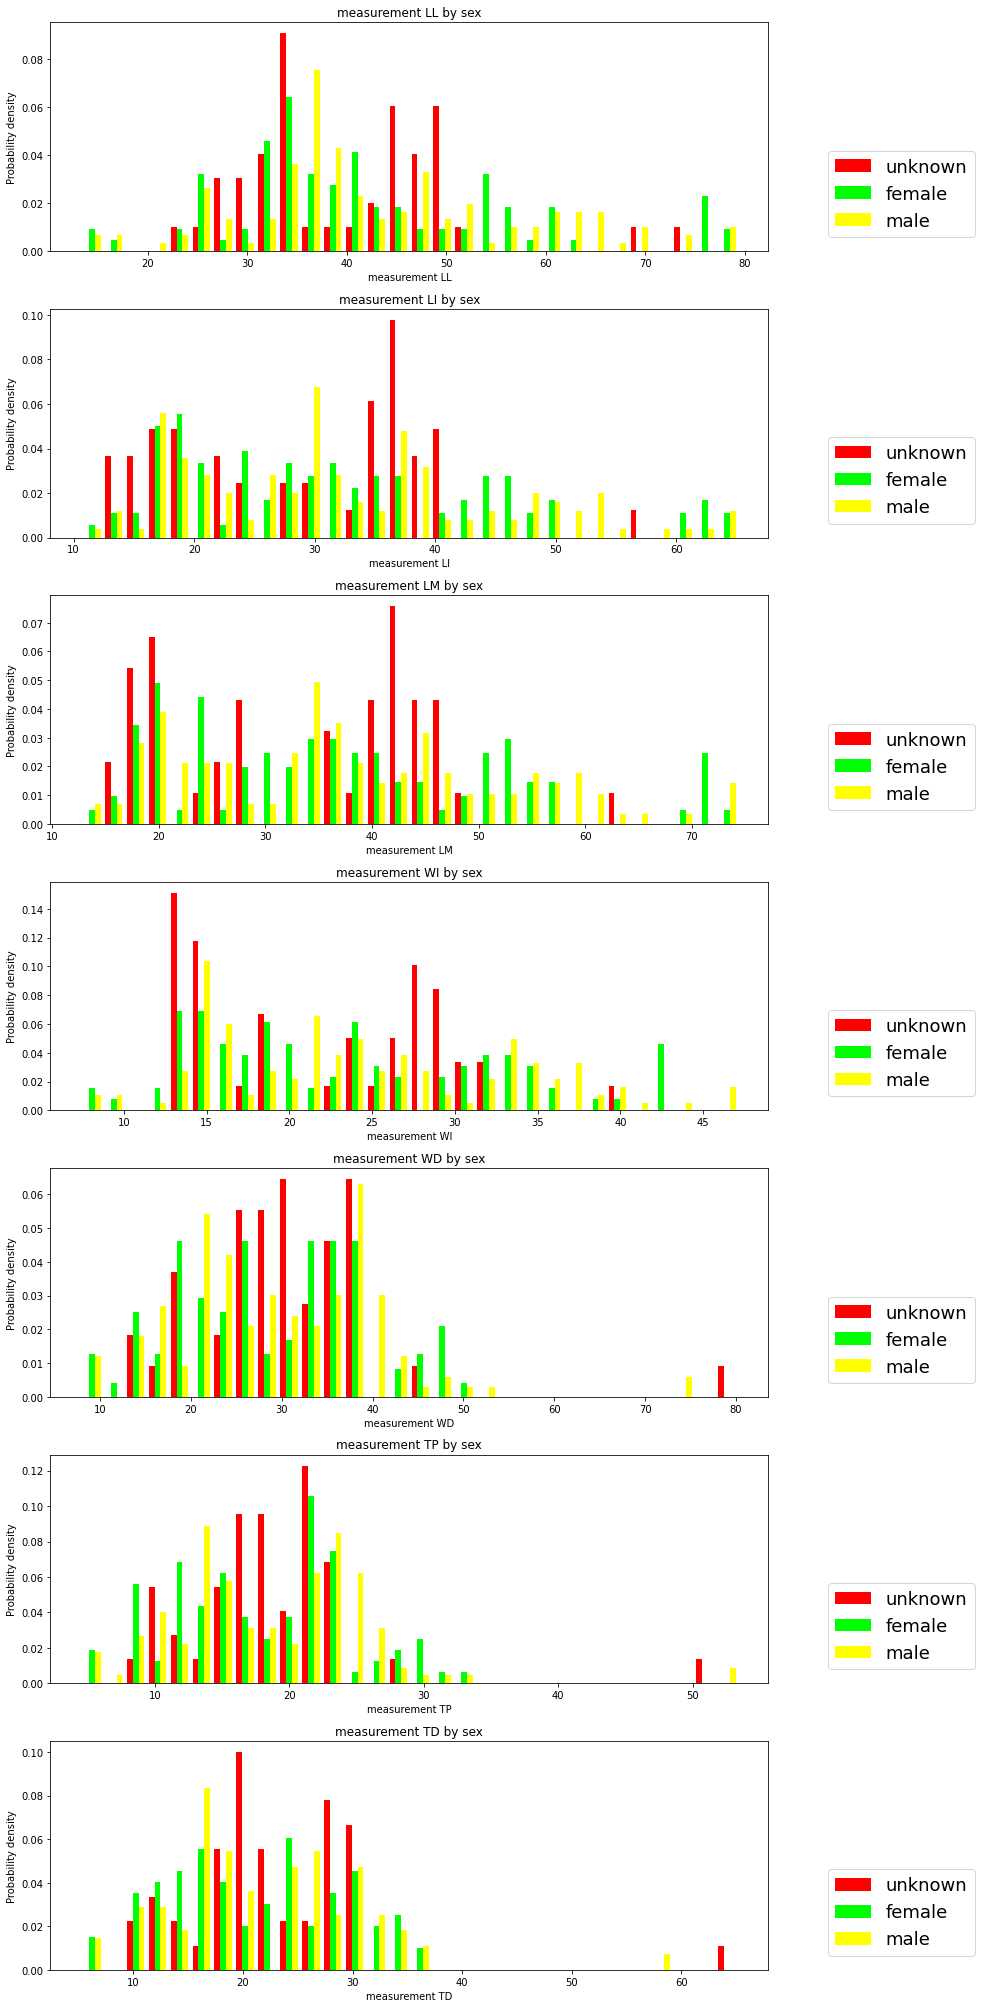

In [26]:
#Frequency plot: Measurements by Sex
fig, axes = plt.subplots(nrows=7, ncols=1, figsize=[14., 28.])
colors = ['red', 'lime', 'yellow']#for unknown, female & male
sexes = ['unknown', 'female', 'male']
n_bins = 30

title_lst = ['measurement LL by sex', 
             'measurement LI by sex', 
             'measurement LM by sex', 
             'measurement WI by sex', 
             'measurement WD by sex', 
             'measurement TP by sex', 
             'measurement TD by sex']

for num, ax in enumerate(axes):
    ax.hist(l_l_s[num], n_bins, density=True, histtype='bar', color=colors, label=sexes)
    ax.set_title(title_lst[num])
    ax.set_xlabel(title_lst[num][:14])
    ax.set_ylabel('Probability density')
    ax.legend(loc=5, bbox_to_anchor=(1.3, 0., 0.0, 0.5), prop={'size': 18})

fig.tight_layout()
plt.show()

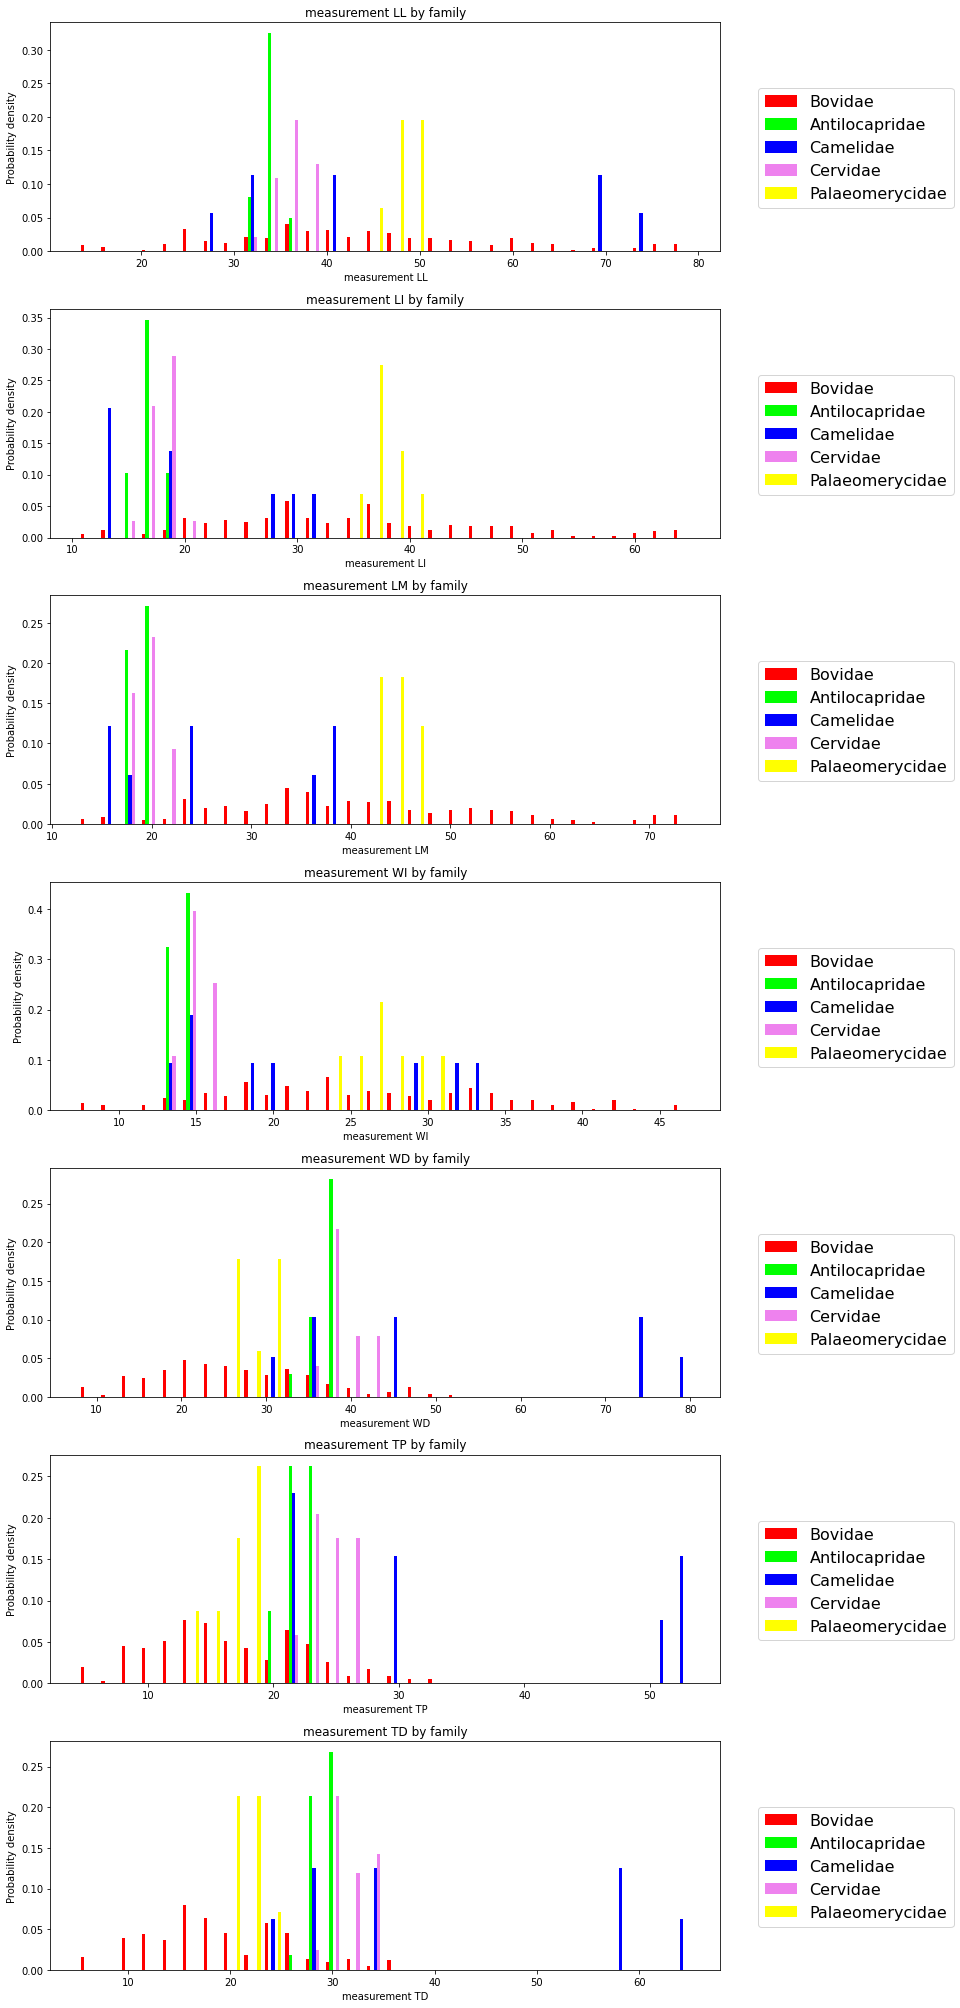

In [27]:
#Frequency plot: Measurements by family
fig, axes = plt.subplots(nrows=7, ncols=1, figsize=[14., 28.])
colors = ['red', 'lime', 'blue', 'violet', 'yellow']

fams = ['Bovidae', 'Antilocapridae', 'Camelidae', 'Cervidae', 'Palaeomerycidae']

n_bins = 30

title_lst = ['measurement LL by family', 
             'measurement LI by family', 
             'measurement LM by family', 
             'measurement WI by family', 
             'measurement WD by family', 
             'measurement TP by family', 
             'measurement TD by family']

for num, ax in enumerate(axes):
    ax.hist(l_l_f[num], n_bins, density=True, histtype='bar', color=colors, label=fams)
    ax.set_title(title_lst[num])
    ax.set_xlabel(title_lst[num][:14])
    ax.set_ylabel('Probability density')
    ax.legend(loc=5, bbox_to_anchor=(1.31, 0.2, 0.05, 0.5), prop={'size': 16})

fig.tight_layout()
plt.show()

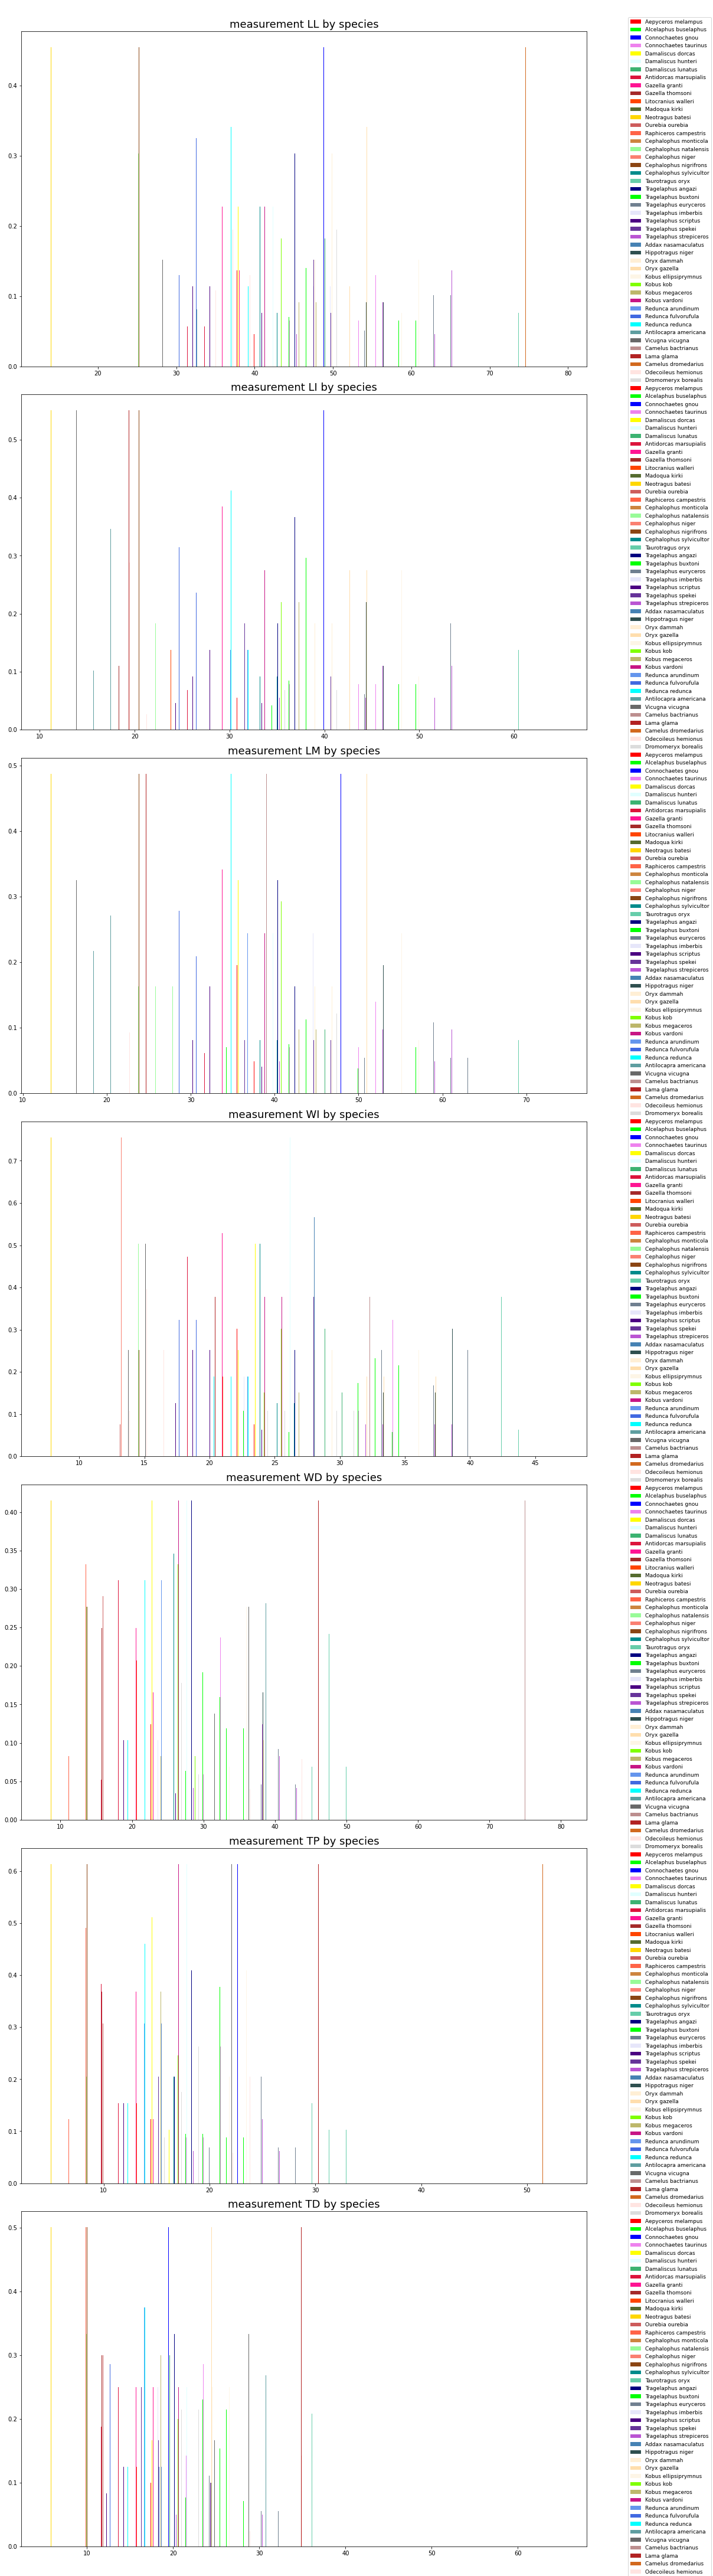

In [28]:
#repeat for species
fig, axes = plt.subplots(nrows=7, ncols=1, figsize=[14., 60.])

colors = ['red', 'lime', 'blue', 'violet', 'yellow', 'lightcyan', 'mediumseagreen', 'crimson', 'deeppink', 'brown', 'orangered', 'darkolivegreen', 'gold', 'indianred', 'tomato', 'peru', 'palegreen', 'salmon', 'saddlebrown', 'darkcyan', 'mediumaquamarine', 'navy', 'lime', 'slategrey', 'lavender', 'indigo', 'rebeccapurple', 'mediumorchid', 'steelblue', 'darkslategrey', 'papayawhip', 'navajowhite', 'oldlace', 'chartreuse', 'darkkhaki', 'mediumvioletred', 'cornflowerblue', 'royalblue', 'aqua', 'cadetblue', 'dimgrey', 'rosybrown', 'firebrick', 'chocolate', 'mistyrose', 'gainsboro']

spec = ['Aepyceros melampus', 'Alcelaphus buselaphus', 'Connochaetes gnou', 'Connochaetes taurinus', 'Damaliscus dorcas', 'Damaliscus hunteri', 'Damaliscus lunatus', 'Antidorcas marsupialis', 'Gazella granti', 'Gazella thomsoni', 'Litocranius walleri', 'Madoqua kirki', 'Neotragus batesi', 'Ourebia ourebia', 'Raphiceros campestris', 'Cephalophus monticola', 'Cephalophus natalensis', 'Cephalophus niger', 'Cephalophus nigrifrons', 'Cephalophus sylvicultor', 'Taurotragus oryx', 'Tragelaphus angazi', 'Tragelaphus buxtoni', 'Tragelaphus euryceros', 'Tragelaphus imberbis', 'Tragelaphus scriptus', 'Tragelaphus spekei', 'Tragelaphus strepiceros', 'Addax nasamaculatus', 'Hippotragus niger', 'Oryx dammah', 'Oryx gazella', 'Kobus ellipsiprymnus', 'Kobus kob', 'Kobus megaceros', 'Kobus vardoni', 'Redunca arundinum', 'Redunca fulvorufula', 'Redunca redunca', 'Antilocapra americana', 'Vicugna vicugna', 'Camelus bactrianus', 'Lama glama', 'Camelus dromedarius', 'Odecoileus hemionus', 'Dromomeryx borealis']

n_bins = 30

title_lst = ['measurement LL by species', 
             'measurement LI by species', 
             'measurement LM by species', 
             'measurement WI by species', 
             'measurement WD by species', 
             'measurement TP by species', 
             'measurement TD by species']

for num, ax in enumerate(axes):
    ax.hist(l_l_p[num], n_bins, density=True, histtype='bar', color=colors, label=spec)
    ax.set_title(title_lst[num], fontsize=18)
fig.legend(loc=5, bbox_to_anchor=(1.3, 0., -.1, 1.), prop={'size': 9})

fig.tight_layout()
plt.show()

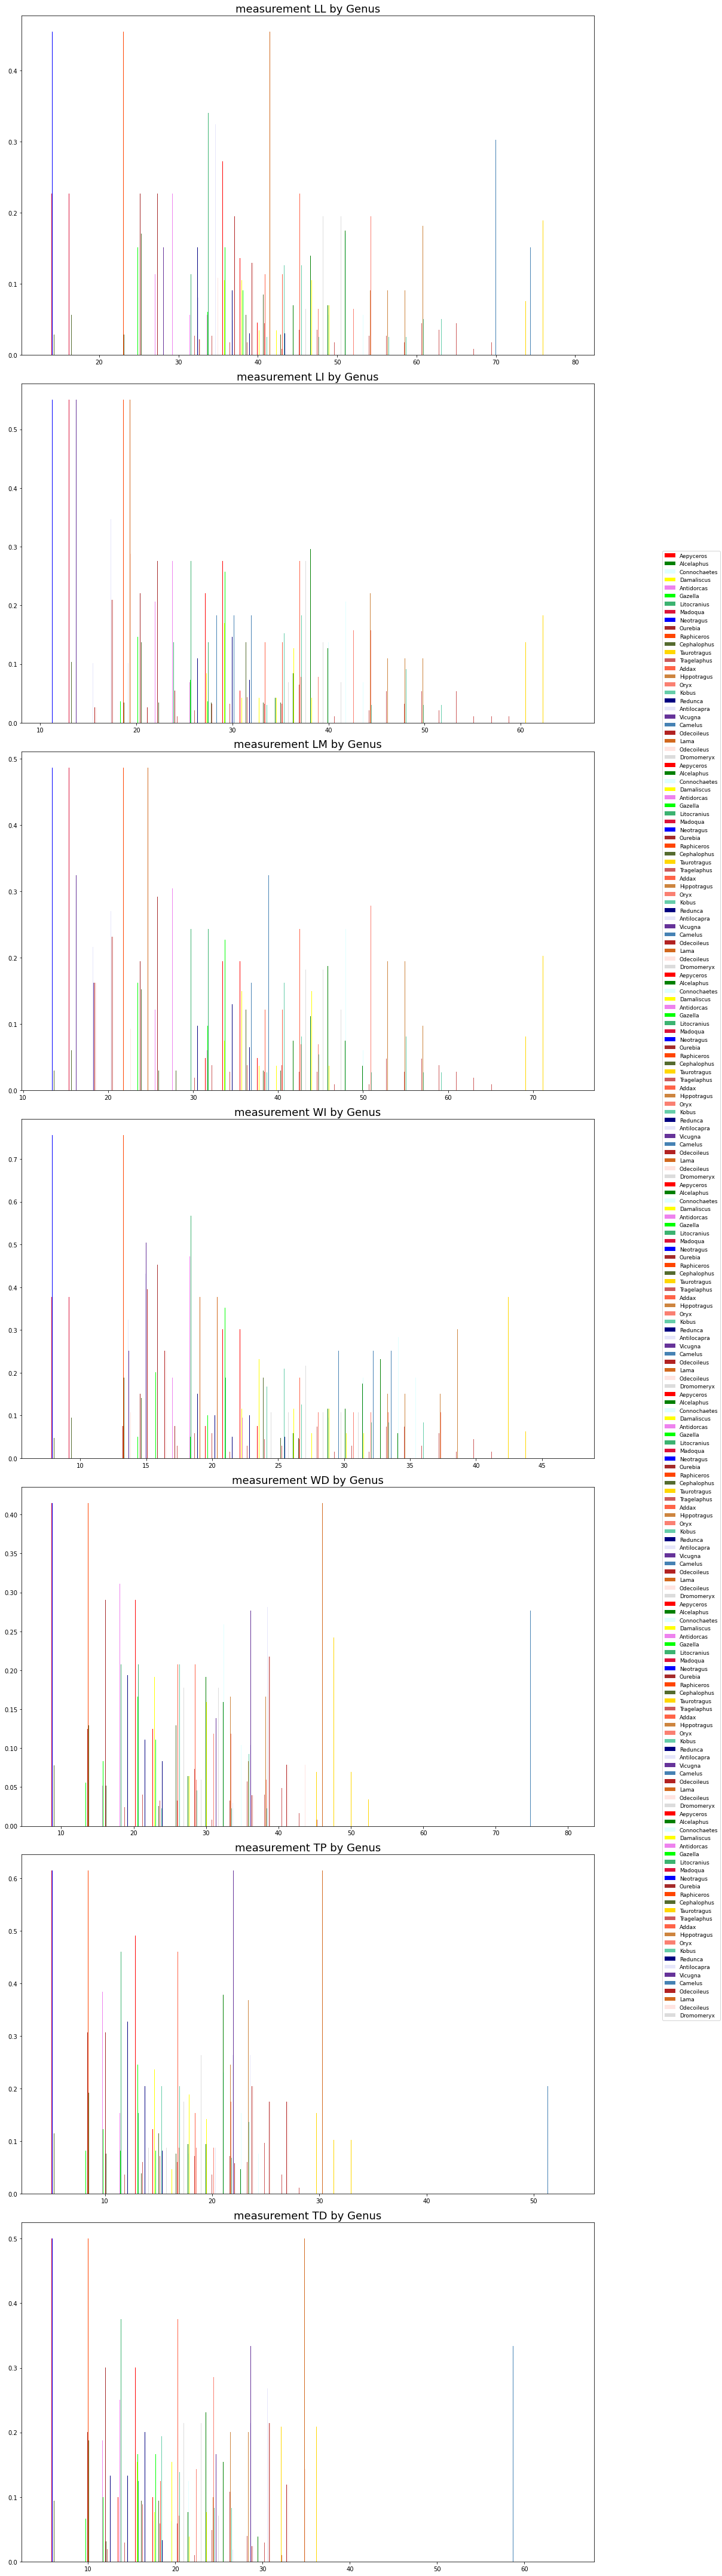

In [29]:
#repeat for Genus
fig, axes = plt.subplots(nrows=7, ncols=1, figsize=[14., 60.])

colors = ['red', 'green', 'lightcyan', 'yellow', 'violet', 'lime', 'mediumseagreen', 'crimson', 'blue', 'brown', 'orangered', 'darkolivegreen', 'gold', 'indianred', 'tomato', 'peru', 'salmon', 'mediumaquamarine', 'navy', 'lavender', 'rebeccapurple', 'steelblue', 'firebrick', 'chocolate', 'mistyrose', 'gainsboro']

Genus = ['Aepyceros', 'Alcelaphus', 'Connochaetes', 'Damaliscus', 'Antidorcas', 'Gazella', 'Litocranius', 'Madoqua', 'Neotragus', 'Ourebia', 'Raphiceros', 'Cephalophus', 'Taurotragus', 'Tragelaphus', 'Addax', 'Hippotragus', 'Oryx', 'Kobus', 'Redunca', 'Antilocapra', 'Vicugna', 'Camelus', 'Odecoileus', 'Lama', 'Odecoileus', 'Dromomeryx']

n_bins = 30

title_lst = ['measurement LL by Genus', 
             'measurement LI by Genus', 
             'measurement LM by Genus', 
             'measurement WI by Genus', 
             'measurement WD by Genus', 
             'measurement TP by Genus', 
             'measurement TD by Genus']

for num, ax in enumerate(axes):
    ax.hist(l_l_g[num], n_bins, density=True, histtype='bar', color=colors, label=Genus)
    ax.set_title(title_lst[num], fontsize=18)
fig.legend(loc=5, bbox_to_anchor=(1.3, 0., -.1, 1.), prop={'size': 9})

fig.tight_layout()
plt.show()

step #3: feature engineering

In [30]:
#remove all entries with any nulls in several subcatagories
df_lengths_sex = df_lengths_sex.dropna()

df_lengths_species = df_lengths_species.dropna()

df_lengths_sub_spec = df_lengths_sub_spec.dropna()

df_lengths_genus = df_lengths_genus.dropna()

steps for later. Come up with an approach to fill nulls? Talk to Win about this.

Step #4: MANOVAs

MANOVA sex as target 

In [31]:
n_samples = df_lengths_sex.shape[0]

In [32]:
n_dim = df_lengths_sex.select_dtypes(include=[np.float]).shape[1]

In [33]:
n_classes = 3
#classes will include: 'male', 'female', and 'unknown' sex

In [34]:
X_man = df_lengths_sex.select_dtypes(include=[np.float])

In [35]:
y_sex_dummies = pd.get_dummies(df_lengths_sex['sex'])

In [36]:
y_unknown_sex = y_sex_dummies.iloc[:,0]

In [37]:
y_female_sex = y_sex_dummies.iloc[:,1]

In [38]:
y_male_sex = y_sex_dummies.iloc[:,2]

In [39]:
manov_u = MANOVA(endog=X_man, exog=y_unknown_sex)

In [40]:
man_res_u = manov_u.mv_test()

In [41]:
print('                     unknown sex MANOVA')
print('')
print(man_res_u)

                     unknown sex MANOVA

                  Multivariate linear model
                                                             
-------------------------------------------------------------
           x0           Value  Num DF  Den DF  F Value Pr > F
-------------------------------------------------------------
          Wilks' lambda 0.8342 8.0000 266.0000  6.6105 0.0000
         Pillai's trace 0.1658 8.0000 266.0000  6.6105 0.0000
 Hotelling-Lawley trace 0.1988 8.0000 266.0000  6.6105 0.0000
    Roy's greatest root 0.1988 8.0000 266.0000  6.6105 0.0000



In [42]:
manov_f = MANOVA(endog=X_man, exog=y_female_sex)

In [43]:
man_res_f = manov_f.mv_test()

In [44]:
print('                      female MANOVA')
print('')
print(man_res_f)

                      female MANOVA

                  Multivariate linear model
                                                             
-------------------------------------------------------------
           x0           Value  Num DF  Den DF  F Value Pr > F
-------------------------------------------------------------
          Wilks' lambda 0.6516 8.0000 266.0000 17.7799 0.0000
         Pillai's trace 0.3484 8.0000 266.0000 17.7799 0.0000
 Hotelling-Lawley trace 0.5347 8.0000 266.0000 17.7799 0.0000
    Roy's greatest root 0.5347 8.0000 266.0000 17.7799 0.0000



In [45]:
manov_m = MANOVA(endog=X_man, exog=y_male_sex)

In [46]:
man_res_m = manov_m.mv_test()

In [47]:
print('                        male MANOVA')
print('')
print(man_res_m)

                        male MANOVA

                  Multivariate linear model
                                                             
-------------------------------------------------------------
           x0           Value  Num DF  Den DF  F Value Pr > F
-------------------------------------------------------------
          Wilks' lambda 0.4926 8.0000 266.0000 34.2466 0.0000
         Pillai's trace 0.5074 8.0000 266.0000 34.2466 0.0000
 Hotelling-Lawley trace 1.0300 8.0000 266.0000 34.2466 0.0000
    Roy's greatest root 1.0300 8.0000 266.0000 34.2466 0.0000



MANOVA species as target

In [48]:
spec_l = list(df_lengths_species['species'].unique())

In [49]:
#use the species list and a dict to assign a family and sub family to each
family_dict = {"Aepyceros melampus":"Bovidae", 
               "Alcelaphus buselaphus":"Bovidae",
               "Connochaetes gnou":"Bovidae",
               "Connochaetes taurinus":"Bovidae",
               "Damaliscus dorcas":"Bovidae",
               "Damaliscus hunteri":"Bovidae",
               "Damaliscus lunatus":"Bovidae",
               "Antidorcas marsupialis":"Bovidae",
               "Gazella granti":"Bovidae",
               "Gazella thomsoni":"Bovidae",
               "Litocranius walleri":"Bovidae",
               "Madoqua kirki":"Bovidae",
               "Neotragus batesi":"Bovidae",
               "Ourebia ourebia":"Bovidae",
               "Raphiceros campestris":"Bovidae",
               "Cephalophus monticola":"Bovidae",
               "Cephalophus natalensis":"Bovidae",
               "Cephalophus niger":"Bovidae",
               "Cephalophus nigrifrons":"Bovidae",
               "Cephalophus sylvicultor":"Bovidae",
               "Taurotragus oryx":"Bovidae",
               "Tragelaphus angazi":"Bovidae",
               "Tragelaphus buxtoni":"Bovidae",
               "Tragelaphus euryceros":"Bovidae",
               "Tragelaphus imberbis":"Bovidae",
               "Tragelaphus scriptus":"Bovidae",
               "Tragelaphus spekei":"Bovidae",
               "Tragelaphus strepiceros":"Bovidae",
               "Addax nasamaculatus":"Bovidae",
               "Hippotragus niger":"Bovidae",
               "Oryx dammah":"Bovidae",
               "Oryx gazella":"Bovidae",
               "Kobus ellipsiprymnus":"Bovidae",
               "Kobus kob":"Bovidae",
               "Kobus megaceros":"Bovidae",
               "Kobus vardoni":"Bovidae",
               "Redunca arundinum":"Bovidae",
               "Redunca fulvorufula":"Bovidae",
               "Redunca redunca":"Bovidae",
               "Antilocapra americana":"Antilocapridae",
               "Vicugna vicugna":"Camelidae",
               "Camelus bactrianus":"Camelidae",
               "Lama glama":"Camelidae",
               "Camelus dromedarius":"Camelidae",
               "Odecoileus hemionus":"Cervidae",
               "Dromomeryx borealis":"Palaeomerycidae"}

In [50]:
family_series = df['species'].map(family_dict)

family_list = list(family_series)
species_list = list(df['species'])
fam_s_l = []
for i, j in zip(family_list, species_list):
    fam_s_l.append(i)
fam_s = pd.Series(fam_s_l)

In [51]:
fam_s.to_csv('families.csv')

In [52]:
y_species_dummies = pd.get_dummies(df_lengths_species['species'])

In [53]:
#loop through the species and generate MANOVAs:
def man_species(df_lengths_species, y_species_dummies):
    X = df_lengths_species.select_dtypes(include=[np.float])
    for num in range(y_species_dummies.shape[1]):
        print(num)
        y = y_species_dummies.iloc[:, num]
        manov_ = MANOVA(endog=X, exog=y) 
        man_res_ = manov_.mv_test()
        print(man_res_)

man_species(df_lengths_species, y_species_dummies)

0
                  Multivariate linear model
                                                             
-------------------------------------------------------------
           x0           Value  Num DF  Den DF  F Value Pr > F
-------------------------------------------------------------
          Wilks' lambda 0.9585 8.0000 272.0000  1.4726 0.1671
         Pillai's trace 0.0415 8.0000 272.0000  1.4726 0.1671
 Hotelling-Lawley trace 0.0433 8.0000 272.0000  1.4726 0.1671
    Roy's greatest root 0.0433 8.0000 272.0000  1.4726 0.1671

1
                  Multivariate linear model
                                                             
-------------------------------------------------------------
           x0           Value  Num DF  Den DF  F Value Pr > F
-------------------------------------------------------------
          Wilks' lambda 0.8966 8.0000 272.0000  3.9207 0.0002
         Pillai's trace 0.1034 8.0000 272.0000  3.9207 0.0002
 Hotelling-Lawley trace 0.1153 8.0000 2

                  Multivariate linear model
                                                             
-------------------------------------------------------------
           x0           Value  Num DF  Den DF  F Value Pr > F
-------------------------------------------------------------
          Wilks' lambda 0.8141 8.0000 272.0000  7.7619 0.0000
         Pillai's trace 0.1859 8.0000 272.0000  7.7619 0.0000
 Hotelling-Lawley trace 0.2283 8.0000 272.0000  7.7619 0.0000
    Roy's greatest root 0.2283 8.0000 272.0000  7.7619 0.0000

14
                  Multivariate linear model
                                                             
-------------------------------------------------------------
           x0           Value  Num DF  Den DF  F Value Pr > F
-------------------------------------------------------------
          Wilks' lambda 0.9477 8.0000 272.0000  1.8759 0.0638
         Pillai's trace 0.0523 8.0000 272.0000  1.8759 0.0638
 Hotelling-Lawley trace 0.0552 8.0000 27

                  Multivariate linear model
                                                             
-------------------------------------------------------------
           x0           Value  Num DF  Den DF  F Value Pr > F
-------------------------------------------------------------
          Wilks' lambda 0.9973 8.0000 272.0000  0.0907 0.9994
         Pillai's trace 0.0027 8.0000 272.0000  0.0907 0.9994
 Hotelling-Lawley trace 0.0027 8.0000 272.0000  0.0907 0.9994
    Roy's greatest root 0.0027 8.0000 272.0000  0.0907 0.9994

29
                  Multivariate linear model
                                                             
-------------------------------------------------------------
           x0           Value  Num DF  Den DF  F Value Pr > F
-------------------------------------------------------------
          Wilks' lambda 0.6036 8.0000 272.0000 22.3271 0.0000
         Pillai's trace 0.3964 8.0000 272.0000 22.3271 0.0000
 Hotelling-Lawley trace 0.6567 8.0000 27

                  Multivariate linear model
                                                             
-------------------------------------------------------------
           x0           Value  Num DF  Den DF  F Value Pr > F
-------------------------------------------------------------
          Wilks' lambda 0.9061 8.0000 272.0000  3.5250 0.0007
         Pillai's trace 0.0939 8.0000 272.0000  3.5250 0.0007
 Hotelling-Lawley trace 0.1037 8.0000 272.0000  3.5250 0.0007
    Roy's greatest root 0.1037 8.0000 272.0000  3.5250 0.0007

42
                  Multivariate linear model
                                                             
-------------------------------------------------------------
           x0           Value  Num DF  Den DF  F Value Pr > F
-------------------------------------------------------------
          Wilks' lambda 0.9105 8.0000 272.0000  3.3418 0.0011
         Pillai's trace 0.0895 8.0000 272.0000  3.3418 0.0011
 Hotelling-Lawley trace 0.0983 8.0000 27

In [54]:
#interpretatation of the MANOVAs here? 
#Talk to Win

Step #5: Use the measurements to train these library based machinine learning algorithms:

RandomForestClassifier

GaussianNB

BernoulliNB

KNeighborsClassifier

DecisionTreeClassifier

GradientBoostingClassifier


...to  predict these catagories:

sex

Genus

species

Step 5a: Random Forest Classifier

Advantages of using Random Forest technique:

Handles higher dimensionality data very well.
Handles missing values and maintains accuracy for missing data.

Disadvantages of using Random Forest technique:

Since final prediction is based on the mean predictions from subset trees, it won’t give precise values for the regression model.

In [55]:
#declare some machine learning models to use on our data
rfc = RandomForestClassifier()
gnb = GaussianNB()
bnb = BernoulliNB()
knn = KNeighborsClassifier()
dtc = DecisionTreeClassifier()
gbc = GradientBoostingClassifier()

In [56]:
#declare functions to fit any of the three kinds of dataframes for sex, Genus and species to these five machine learning models 
#takes the measurements and target variable (as the final column)
def rfc_m(rfc, dfXy):
    X, y = dfXy.iloc[:,:-1], dfXy.iloc[:,-1]
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 0)
    rfc_model = rfc.fit(X_train, y_train)
    return rfc_model

def gnb_m(gnb, dfXy):
    X, y = dfXy.iloc[:,:-1], dfXy.iloc[:,-1]
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 0)
    gnb_model = gnb.fit(X_train, y_train)
    return gnb_model

def bnb_m(bnb, dfXy):
    X, y = dfXy.iloc[:,:-1], dfXy.iloc[:,-1]
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 0)
    bnb_model = gnb.fit(X_train, y_train)
    return bnb_model

def knn_m(knn, dfXy):
    X, y = dfXy.iloc[:,:-1], dfXy.iloc[:,-1]
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 0)
    knn_model = knn.fit(X_train, y_train)
    return knn_model

def dtc_m(dtc, dfXy):
    X, y = dfXy.iloc[:,:-1], dfXy.iloc[:,-1]
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 0)
    dtc_model = dtc.fit(X_train, y_train)
    return dtc_model

def gbc_m(gbc, dfXy):
    X, y = dfXy.iloc[:,:-1], dfXy.iloc[:,-1]
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 0)
    gbc_model = gbc.fit(X_train, y_train)
    return gbc_model

In [57]:
algorithms = [rfc, gnb, bnb, knn, dtc, gbc]
names = ['Random Forest', 
         'GaussianNB', 
         'BernoulliNB', 
         'K Nearest', 
         'Decision Tree', 
         'Gradient Boost'
        ]

evaluate the random forest models using accuracy_score, precision_score, recall_score, f1_score

In [58]:
#Use this one at a time on the dependant features

#compare the preformance of these modeles using a confusion matrix. 
def evaluate_model(Xy, algorithms = algorithms, names = names):
    X, y = Xy.iloc[:,:-1], Xy.iloc[:,-1]
    for i in range(len(algorithms)):
        algorithms[i] = algorithms[i].fit(X, y)
    accuracy = []
    precision = []
    recall = []
    f1 = []
    for i in range(len(algorithms)):
        if accuracy_score(y, algorithms[i].predict(X)) == 1:
            accuracy.append(0)
        else:   
            accuracy.append(accuracy_score(y, algorithms[i].predict(X)))
        #if precision_score(y, algorithms[i].predict(X)) == 1:
        if precision_score(y, algorithms[i].predict(X), average = 'weighted') == 1:   
            precision.append(0)
        else:   
            precision.append(accuracy_score(y, algorithms[i].predict(X)))
        if recall_score(y, algorithms[i].predict(X), average = 'weighted') == 1:
            recall.append(0)
        else:   
            recall.append(accuracy_score(y, algorithms[i].predict(X)))
        if f1_score(y, algorithms[i].predict(X), average = 'weighted') == 1:
            f1.append(0)
        else:   
            f1.append(accuracy_score(y, algorithms[i].predict(X)))
    metrics = pd.DataFrame(columns = ['Accuracy', 'Precision', 'Recall', 'F1'], index = names)
    metrics['Accuracy'] = accuracy
    metrics['Precision'] = precision
    metrics['Recall'] = recall
    metrics['F1'] = f1
    return metrics.sort_values('Accuracy', ascending = False)

In [59]:
#evaluate the models preformance for 'sex'
evaluate_model(df_lengths_sex)
#Why don't I get values reported for random forst, decision tree and gradient boost?
#Are the fit's 'too good' / not real and being set to zero by the function?
#I assume so. I'll have to find another way 

/Users/Nicholas/Desktop/Data Science Immersion/venvp3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Accuracy,Precision,Recall,F1
K Nearest,0.686131,0.686131,0.686131,0.686131
BernoulliNB,0.503650,0.503650,0.503650,0.503650
GaussianNB,0.423358,0.423358,0.423358,0.423358
Random Forest,0.000000,0.000000,0.000000,0.000000
Decision Tree,0.000000,0.000000,0.000000,0.000000
Gradient Boost,0.000000,0.000000,0.000000,0.000000


In [60]:
#evalutate the models preformance for 'Genus'
evaluate_model(df_lengths_genus)

/Users/Nicholas/Desktop/Data Science Immersion/venvp3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Nicholas/Desktop/Data Science Immersion/venvp3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Nicholas/Desktop/Data Science Immersion/venvp3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, m

,Accuracy,Precision,Recall,F1
K Nearest,0.721429,0.721429,0.721429,0.721429
GaussianNB,0.521429,0.521429,0.521429,0.521429
BernoulliNB,0.182143,0.182143,0.182143,0.182143
Random Forest,0.000000,0.000000,0.000000,0.000000
Decision Tree,0.000000,0.000000,0.000000,0.000000
Gradient Boost,0.000000,0.000000,0.000000,0.000000


In [61]:
#evaluate the models preformance for 'species'
evaluate_model(df_lengths_species)

/Users/Nicholas/Desktop/Data Science Immersion/venvp3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Nicholas/Desktop/Data Science Immersion/venvp3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Nicholas/Desktop/Data Science Immersion/venvp3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, m

,Accuracy,Precision,Recall,F1
GaussianNB,0.660714,0.660714,0.660714,0.660714
K Nearest,0.657143,0.657143,0.657143,0.657143
BernoulliNB,0.096429,0.096429,0.096429,0.096429
Random Forest,0.000000,0.000000,0.000000,0.000000
Decision Tree,0.000000,0.000000,0.000000,0.000000
Gradient Boost,0.000000,0.000000,0.000000,0.000000


Present the probabilty of being each sex, Genus, and species for each measurement.
Current idea: save a csv containing the true value, the predictd value and the confidence

In [62]:
#make predictions with GuassianNB, K Nearest, BernouliNB, Random Forest, Decision Tree, 
#Gradient Boost

import random

def n_split(n, df_mea_cat):
    rand_ord_lst = []
    row_index = list(range(len(df_mea_cat.index)))
    random.shuffle(row_index)#define a randomly order list of indices to divide them up
    k, m = divmod(len(row_index), n)
    return (row_index[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in range(n))

In [64]:
#create three split versions of the dataframe containing bool column for 1 = {female, male '?'}
y_sex = df_lengths_sex.iloc[:,-1]
y_sex_dummies = pd.get_dummies(y_sex)
y_unknown = y_sex_dummies.iloc[:,0]#unknown
y_female = y_sex_dummies.iloc[:,1]#female
y_male = y_sex_dummies.iloc[:,2]#male
X_sex = df_lengths_sex.iloc[:,:-1]
Xy_f = pd.concat([X_sex, y_female], axis=1)
Xy_m = pd.concat([X_sex, y_male], axis=1)
Xy_u = pd.concat([X_sex, y_unknown], axis=1)

In [65]:
def df_predict(X_train, y_train, X_test, y_test):#change this so it just takes the training and the test df as seperat variables
    #define models to run on the splits
    algorithms = [rfc, gnb, bnb, knn, dtc, gbc]
    names = ['Random Forest', 
             'GaussianNB', 
             'BernoulliNB', 
             'K Nearest', 
             'Decision Tree', 
             'Gradient Boost']
    
    #define some list to hold the accuracy, precision, recall, and f1 score
    accuracy, precision, recall, f1 = [], [], [], []
    
    #define a list to hold the preictions for each individual algorithm
    algs = []
    
    #define a list to hold the predictions and the probabilty of class membership
    pred_lst, prob_lst = [], []
    
    for i in range(len(algorithms)):
        cur_alg = algorithms[i].fit(X_train, y_train)
        accuracy.append(accuracy_score(y_test, cur_alg.predict(X_test)))
        precision.append(precision_score(y_test, cur_alg.predict(X_test)))
        recall.append(recall_score(y_test, cur_alg.predict(X_test)))
        f1.append(f1_score(y_test, cur_alg.predict(X_test)))
        pred_lst.append(cur_alg.predict_proba(X_test))
        prob_lst.append(cur_alg.predict(X_test))
    return pred_lst, prob_lst, accuracy, precision, recall, f1

In [66]:
#Make a function to create 'n' splits and successively loop through different splits to predict values for y.

#use the kfold method:
from sklearn.model_selection import KFold

def split_and_lst(Xy):
    X, y = Xy.iloc[:,:-1], Xy.iloc[:,-1]
    #side note: I believe I can always get the same result if I used the same integer random state
    kf = KFold(n_splits=10)
    kf.get_n_splits(X)
    X_train_lst, y_train_lst, X_test_lst, y_test_lst = [], [], [], []
    for train_index, test_index in kf.split(X):
        #print("TRAIN:", train_index, "TEST:", test_index)
        #print(type(train_index))#numpy.ndarray
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        X_train_lst.append(X_train)
        y_train_lst.append(y_train)
        X_test_lst.append(X_test)
        y_test_lst.append(y_test)
    return X_train_lst, y_train_lst, X_test_lst, y_test_lst

X_train_lst, y_train_lst, X_test_lst, y_test_lst = split_and_lst(Xy_f)

In [99]:
def mean(lst): 
    return sum(lst) / len(lst)

In [103]:
def model_splits(X_train_lst, y_train_lst, X_test_lst, y_test_lst):
    
    rfc_predict, gnb_predict, bnb_predict, knn_predict, dtc_predict, gbc_predict = [], [], [], [], [], []
    rfc_proba, gnb_proba, bnb_proba, knn_proba, dtc_proba, gbc_proba = [], [], [], [], [], []
    rfc_accuracy, rfc_precision, rfc_recall, rfc_f1 = [], [], [], []
    gnb_accuracy, gnb_precision, gnb_recall, gnb_f1 = [], [], [], []
    bnb_accuracy, bnb_precision, bnb_recall, bnb_f1 = [], [], [], []
    knn_accuracy, knn_precision, knn_recall, knn_f1 = [], [], [], []
    dtc_accuracy, dtc_precision, dtc_recall, dtc_f1 = [], [], [], []
    gbc_accuracy, gbc_precision, gbc_recall, gbc_f1 = [], [], [], []
    
    acc_lst, prc_lst, rcl_lst, f1_lst, predict_lst, proba_lst = [], [], [], [], [], []
    
    for X_train, y_train, X_test, y_test in zip(X_train_lst, y_train_lst, X_test_lst, y_test_lst):
        
        pred_lst, prob_lst, accuracy, precision, recall, f1 = df_predict(X_train, y_train, X_test, y_test)
        
        #rfc_accuracy.append(accuracy[0])
        #gnb_accuracy.append(accuracy[1])
        #bnb_accuracy.append(accuracy[2])
        #knn_accuracy.append(accuracy[3])
        #dtc_accuracy.append(accuracy[4])
        #gbc_accuracy.append(accuracy[5])
        acc_lst.append(accuracy)
        
        #rfc_precision.append(precision[0])
        #gnb_precision.append(precision[1])
        #bnb_precision.append(precision[2])
        #knn_precision.append(precision[3])
        #dtc_precision.append(precision[4])
        #gbc_precision.append(precision[5])
        prc_lst.append(precision)
        
        #rfc_recall.append(recall[0])
        #gnb_recall.append(recall[1])
        #bnb_recall.append(recall[2])
        #knn_recall.append(recall[3])
        #dtc_recall.append(recall[4])
        #gbc_recall.append(recall[5])
        rcl_lst.append(recall)
        
        #rfc_f1.append(f1[0])
        #gnb_f1.append(f1[1])
        #bnb_f1.append(f1[2])
        #knn_f1.append(f1[3])
        #dtc_f1.append(f1[4])
        #gbc_f1.append(f1[5])
        f1_lst.append(f1)

        #rfc_predict.append(pred_lst[0])
        #gnb_predict.append(pred_lst[1])
        #bnb_predict.append(pred_lst[2])
        #knn_predict.append(pred_lst[3])
        #dtc_predict.append(pred_lst[4])
        #gbc_predict.append(pred_lst[5])
        predict_lst.append(pred_lst)
        
        #rfc_proba.append(prob_lst[0])
        #gnb_proba.append(prob_lst[1])
        #bnb_proba.append(prob_lst[2])
        #knn_proba.append(prob_lst[3])
        #dtc_proba.append(prob_lst[4])
        #gbc_proba.append(prob_lst[5])
        proba_lst.append(prob_lst)
    
    #get stat measures averaged over all splits for each model
    #av_rfc_acc = mean(rfc_accuracy)
    #av_gnb_acc = mean(gnb_accuracy)
    #av_bnb_acc = mean(bnb_accuracy)
    #av_knn_acc = mean(knn_accuracy)
    #av_dtc_acc = mean(dtc_accuracy)
    #av_gbc_acc = mean(gbc_accuracy)
    
    #av_rfc_prc = mean(rfc_precision)
    #av_gnb_prc = mean(gnb_precision)
    #av_bnb_prc = mean(bnb_precision)
    #av_knn_prc = mean(knn_precision)
    #av_dtc_prc = mean(dtc_precision)
    #av_gbc_prc = mean(gbc_precision)    
    
    #av_rfc_rcl = mean(rfc_recall)
    #av_gnb_rcl = mean(gnb_recall)
    #av_bnb_rcl = mean(bnb_recall)
    #av_knn_rcl = mean(knn_recall)
    #av_dtc_rcl = mean(dtc_recall)
    #av_gbc_rcl = mean(gbc_recall)
    
    #av_rfc_f1 = mean(rfc_recall)
    #av_gnb_f1 = mean(gnb_recall)
    #av_bnb_f1 = mean(bnb_recall)
    #av_knn_f1 = mean(knn_recall)
    #av_dtc_f1 = mean(dtc_recall)
    #av_gbc_f1 = mean(gbc_recall)
    
    model_accuracies = [mean(item[0]) for item in zip(acc_lst)]
    #model_accuracy = []
    #for stat in acc_lst:
    #    ms = mean(stat)
    #    model_accuracy.append(ms)
    
    model_precisions = [mean(item[0]) for item in zip(prc_lst)]
    #model_precision = []
    #for stat in prc_lst:
    #    ms = mean(stat)
    #    model_precision.append(ms)
        
    model_recalls = [mean(item[0]) for item in zip(rcl_lst)]
    #model_recall = []
    #for stat in rcl_lst:
    #    ms = mean(stat)
    #    model_recall.append(ms)
    
    model_f1s = [mean(item[0]) for item in zip(f1_lst)]
    #model_f1 = []
    #for stat in f1_lst:
    #    ms = mean(stat)
    #    model_f1.append(ms)
        
    #rfc_pred_y = np.empty((0, 2))
    #for splt in rfc_predict:
    #    rfc_pred_y = np.concatenate((rfc_pred_y, splt), axis=0)
    
    #gnb_pred_y = np.empty((0, 2))
    #for splt in gnb_predict:
    #    gnb_pred_y = np.concatenate((gnb_pred_y, splt), axis=0)
    
    #bnb_pred_y = np.empty((0, 2))
    #for splt in bnb_predict:
    #    bnb_pred_y = np.concatenate((bnb_pred_y, splt), axis=0)
        
    #knn_pred_y = np.empty((0, 2))
    #for splt in knn_predict:
    #    knn_pred_y = np.concatenate((knn_pred_y, splt), axis=0)
        
    #dtc_pred_y = np.empty((0, 2))
    #for splt in dtc_predict:
    #    dtc_pred_y = np.concatenate((dtc_pred_y, splt), axis=0)

    #gbc_pred_y = np.empty((0, 2))
    #for splt in gbc_predict:
    #    gbc_pred_y = np.concatenate((gbc_pred_y, splt), axis=0)
    
    num_cols = len(predict_lst[0]) * 2#times 2 because predict returns double columns
    mod_prd_hldr = np.empty((0, num_cols))
    for models in predict_lst:
        pred_hldr = np.empty((len(models[0]), num_cols))
        for i in range(len(models)):
            a, b = i*2, i*2+2
            cur_pred = models[i]
            pred_hldr[:, a:b] = cur_pred        
        mod_prd_hldr = np.vstack((mod_prd_hldr, pred_hldr))
    
    mod_prb_hldr = np.empty((0, num_cols))
    for models in proba_lst:
        prob_hldr = np.empty((len(models[0]), num_cols))
        for i in range(len(models)):
            a, b = i*2, i*2+1
            cur_prob = models[i]
            prob_hldr[:, a:b] = np.reshape(cur_prob, (len(cur_prob), 1))
        mod_prb_hldr = np.vstack((mod_prb_hldr, prob_hldr))
    
    return mod_prd_hldr, mod_prb_hldr, model_accuracies, model_precisions, model_recalls, model_f1s

mod_prd_hldr, mod_prb_hldr, model_accuracies, model_precisions, model_recalls, model_f1s = model_splits(X_train_lst, y_train_lst, X_test_lst, y_test_lst)

Step #6: Use the measurements to train a neural network to  predict these catagories for some synthticly generated measurements:

sex

Genus

species